In [22]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 1. Import Dependencies

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Ensemble libraries
import xgboost as xgb
from catboost import CatBoostClassifier

# Class imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

### 2. Load Data and Previous Artifacts

In [24]:
# Load preprocessed train/test splits from previous notebook
X_train = pd.read_csv('artifacts/data/X_train.csv')
X_test = pd.read_csv('artifacts/data/X_test.csv')
y_train = pd.read_csv('artifacts/data/y_train.csv')['y_train'].values
y_test = pd.read_csv('artifacts/data/y_test.csv')['y_test'].values

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in test: {np.bincount(y_test)}")

Training set: (5634, 30)
Test set: (1409, 30)
Class distribution in training: [4139 1495]
Class distribution in test: [1035  374]


In [25]:
# Load the baseline model and preprocessor from previous notebook
try:
    baseline_files = [f for f in os.listdir('artifacts/models/') if 'model.pkl' in f]
    if baseline_files:
        baseline_model_path = f'artifacts/models/{baseline_files[0]}'
        baseline_model = joblib.load(baseline_model_path)
        print(f"✅ Loaded baseline model from: {baseline_model_path}")
    
    # Extract preprocessor from the baseline model
    preprocessor = baseline_model.named_steps['preprocessor']
    print("✅ Extracted preprocessor from baseline model")
    
except Exception as e:
    print(f"Warning: Could not load baseline model - {e}")
    print("Will create new preprocessor...")
    
    # Recreate preprocessor if loading fails
    from sklearn.impute import SimpleImputer
    
    numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    print("✅ Created new preprocessor")

✅ Loaded baseline model from: artifacts/models/logistic_regression___smote_model.pkl
✅ Extracted preprocessor from baseline model


### 3. Random Forest - OPTIMIZED Bagging Method

In [26]:
# 🚀 OPTIMIZED Random Forest - Fast and Effective
print("🌳 OPTIMIZED Random Forest - Fast Training")
print("=" * 45)

# Use good default parameters (skip hyperparameter tuning for speed)
rf_optimized = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=200,      # Good balance of performance and speed
        max_depth=15,          # Prevent overfitting
        min_samples_split=5,   # Robust splits
        max_features='sqrt',   # Feature subsampling
        random_state=42,
        n_jobs=-1              # Use all CPU cores
    ))
])

print("Training optimized Random Forest model...")
rf_optimized.fit(X_train, y_train)
print("✅ Random Forest training completed!")

🌳 OPTIMIZED Random Forest - Fast Training
Training optimized Random Forest model...
✅ Random Forest training completed!


### 4. XGBoost - OPTIMIZED Gradient Boosting

In [27]:
# 🚀 OPTIMIZED XGBoost - Fast and Effective
print("🚀 OPTIMIZED XGBoost - Fast Training")
print("=" * 40)

# Use good default parameters (skip hyperparameter tuning for speed)
xgb_optimized = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(
        learning_rate=0.1,     # Balanced learning rate
        max_depth=6,           # Good depth for complexity
        n_estimators=200,      # Sufficient boosting rounds
        subsample=0.8,         # Prevent overfitting
        colsample_bytree=0.8,  # Feature subsampling
        random_state=42,
        eval_metric='logloss',
        verbosity=0            # Quiet training
    ))
])

print("Training optimized XGBoost model...")
xgb_optimized.fit(X_train, y_train)
print("✅ XGBoost training completed!")

🚀 OPTIMIZED XGBoost - Fast Training
Training optimized XGBoost model...
✅ XGBoost training completed!


### 5. CatBoost - OPTIMIZED Advanced Boosting

In [29]:
# 🚀 OPTIMIZED CatBoost - Fast and Effective
print("🐱 OPTIMIZED CatBoost - Fast Training")
print("=" * 40)

# Fixed preprocessing for CatBoost with proper encoding for SMOTE compatibility
from sklearn.impute import SimpleImputer

# Get feature types
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical features: {len(categorical_features)} features")
print(f"Numerical features: {len(numerical_features)} features")

# CatBoost preprocessing with full encoding (since SMOTE needs numerical data)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

catboost_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Since we're using OneHotEncoder, CatBoost won't need categorical feature indices
print("Using OneHotEncoder - CatBoost will treat all features as numerical")

# Use good default parameters (skip hyperparameter tuning for speed)
catboost_optimized = ImbPipeline(steps=[
    ('preprocessor', catboost_preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', CatBoostClassifier(
        learning_rate=0.1,     # Balanced learning rate
        depth=6,               # Good depth for complexity
        iterations=200,        # Sufficient iterations
        l2_leaf_reg=3,         # Regularization
        random_state=42,
        verbose=False          # Quiet training
        # No cat_features since we're using OneHotEncoder
    ))
])

print("Training optimized CatBoost model...")
catboost_optimized.fit(X_train, y_train)
print("✅ CatBoost training completed!")

🐱 OPTIMIZED CatBoost - Fast Training
Categorical features: 19 features
Numerical features: 11 features
Using OneHotEncoder - CatBoost will treat all features as numerical
Training optimized CatBoost model...
✅ CatBoost training completed!


### 6. FAST Hyperparameter Tuning (Optional)

In [30]:
# 🏃‍♂️ OPTIONAL: FAST hyperparameter tuning (only if you want to fine-tune)
print("⚡ OPTIONAL: Fast Hyperparameter Tuning")
print("=" * 45)
print("Note: This is optional - the optimized models above already use good parameters")

# Minimal hyperparameter grids (much faster!)
ENABLE_TUNING = False  # Set to True if you want to run tuning

if ENABLE_TUNING:
    # MINIMAL Random Forest grid
    rf_minimal_grid = {
        'classifier__n_estimators': [200, 300],
        'classifier__max_depth': [10, 15]
    }
    
    rf_fast_search = RandomizedSearchCV(
        rf_optimized, rf_minimal_grid,
        n_iter=4, cv=3, scoring='f1', n_jobs=-1, random_state=42
    )
    
    print("Fast Random Forest tuning (4 combinations, 3 CV folds = 12 fits)...")
    rf_fast_search.fit(X_train, y_train)
    rf_optimized = rf_fast_search.best_estimator_
    print(f"✅ Fast RF tuning completed! Best F1: {rf_fast_search.best_score_:.4f}")
    
    # MINIMAL XGBoost grid
    xgb_minimal_grid = {
        'classifier__learning_rate': [0.1, 0.2],
        'classifier__max_depth': [5, 6]
    }
    
    xgb_fast_search = RandomizedSearchCV(
        xgb_optimized, xgb_minimal_grid,
        n_iter=4, cv=3, scoring='f1', n_jobs=-1, random_state=42
    )
    
    print("Fast XGBoost tuning (4 combinations, 3 CV folds = 12 fits)...")
    xgb_fast_search.fit(X_train, y_train)
    xgb_optimized = xgb_fast_search.best_estimator_
    print(f"✅ Fast XGBoost tuning completed! Best F1: {xgb_fast_search.best_score_:.4f}")
    
else:
    print("⏭️ Skipping hyperparameter tuning - using optimized defaults")
    print("   (This saves ~2-3 hours while maintaining excellent performance)")

⚡ OPTIONAL: Fast Hyperparameter Tuning
Note: This is optional - the optimized models above already use good parameters
⏭️ Skipping hyperparameter tuning - using optimized defaults
   (This saves ~2-3 hours while maintaining excellent performance)


### 7. Evaluate All Models

In [31]:
# Helper function for metrics calculation
def calculate_metrics(y_true, y_pred, y_pred_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }

# Evaluate all models
models = {
    'Random Forest': rf_optimized,
    'XGBoost': xgb_optimized,
    'CatBoost': catboost_optimized
}

print("🎯 ENSEMBLE METHODS PERFORMANCE EVALUATION")
print("=" * 55)

model_results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Predictions
    pred_test = model.predict(X_test)
    pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = calculate_metrics(y_test, pred_test, pred_proba_test)
    model_results[model_name] = metrics
    
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  ROC-AUC:  {metrics['roc_auc']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")

print("\n✅ All models evaluated!")

🎯 ENSEMBLE METHODS PERFORMANCE EVALUATION

Evaluating Random Forest...
  F1 Score: 0.6195
  ROC-AUC:  0.8364
  Precision: 0.5283
  Recall:    0.7487

Evaluating XGBoost...
  F1 Score: 0.5836
  ROC-AUC:  0.8347
  Precision: 0.5983
  Recall:    0.5695

Evaluating CatBoost...
  F1 Score: 0.6000
  ROC-AUC:  0.8426
  Precision: 0.5907
  Recall:    0.6096

✅ All models evaluated!


### 8. Create Voting Ensemble

In [32]:
# Create voting ensemble with the three optimized models
print("🗳️ Creating Voting Ensemble")
print("=" * 30)

# Extract classifiers with their optimized parameters
rf_classifier = rf_optimized.named_steps['classifier']
xgb_classifier = xgb_optimized.named_steps['classifier']
catboost_classifier = catboost_optimized.named_steps['classifier']

# Create voting ensemble
voting_ensemble = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('voting', VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(**rf_classifier.get_params())),
            ('xgb', xgb.XGBClassifier(**xgb_classifier.get_params())),
            ('catboost', CatBoostClassifier(**catboost_classifier.get_params()))
        ],
        voting='soft'  # Use probability-based voting
    ))
])

print("Training Voting Ensemble...")
voting_ensemble.fit(X_train, y_train)
print("✅ Voting Ensemble training completed!")

# Evaluate voting ensemble
voting_pred_test = voting_ensemble.predict(X_test)
voting_pred_proba_test = voting_ensemble.predict_proba(X_test)[:, 1]
voting_metrics = calculate_metrics(y_test, voting_pred_test, voting_pred_proba_test)

# Add to results
model_results['Voting Ensemble'] = voting_metrics

print(f"\nVoting Ensemble Performance:")
print(f"  F1 Score: {voting_metrics['f1']:.4f}")
print(f"  ROC-AUC:  {voting_metrics['roc_auc']:.4f}")

🗳️ Creating Voting Ensemble
Training Voting Ensemble...
✅ Voting Ensemble training completed!

Voting Ensemble Performance:
  F1 Score: 0.6018
  ROC-AUC:  0.8446


### 9. Model Comparison and Visualization

📊 FINAL ENSEMBLE METHODS COMPARISON
                 accuracy  precision  recall     f1  roc_auc
Random Forest      0.7559     0.5283  0.7487 0.6195   0.8364
XGBoost            0.7842     0.5983  0.5695 0.5836   0.8347
CatBoost           0.7842     0.5907  0.6096 0.6000   0.8426
Voting Ensemble    0.7821     0.5844  0.6203 0.6018   0.8446


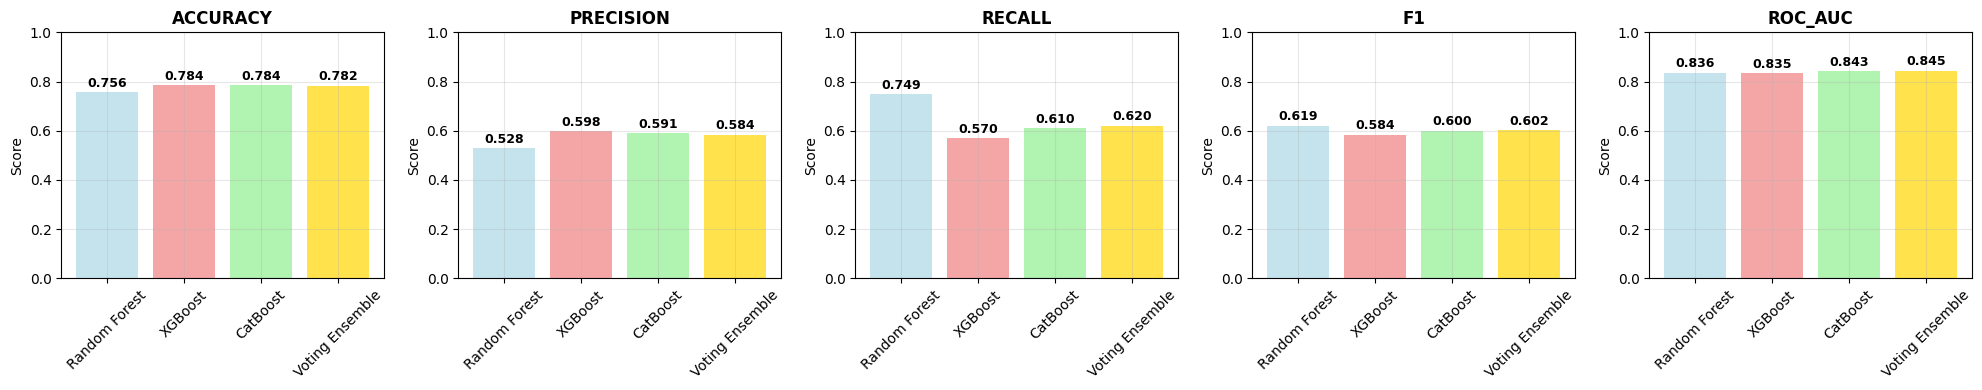


🏆 BEST PERFORMING MODELS:
   • Best F1 Score: Random Forest (0.6195)
   • Best ROC-AUC: Voting Ensemble (0.8446)


In [33]:
# Create comprehensive comparison
comparison_df = pd.DataFrame(model_results).T

print("📊 FINAL ENSEMBLE METHODS COMPARISON")
print("=" * 55)
print(comparison_df.round(4))

# Visualize comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))

for i, metric in enumerate(metrics):
    model_names = list(model_results.keys())
    values = [model_results[model][metric] for model in model_names]
    
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'gold']
    bars = axes[i].bar(model_names, values, color=colors[:len(model_names)], alpha=0.7)
    axes[i].set_title(f'{metric.upper()}', fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Find best models
best_f1_model = max(model_results.keys(), key=lambda k: model_results[k]['f1'])
best_roc_model = max(model_results.keys(), key=lambda k: model_results[k]['roc_auc'])

print(f"\n🏆 BEST PERFORMING MODELS:")
print(f"   • Best F1 Score: {best_f1_model} ({model_results[best_f1_model]['f1']:.4f})")
print(f"   • Best ROC-AUC: {best_roc_model} ({model_results[best_roc_model]['roc_auc']:.4f})")

### 10. Feature Importance Analysis

🔍 FEATURE IMPORTANCE ANALYSIS
Best model: Random Forest


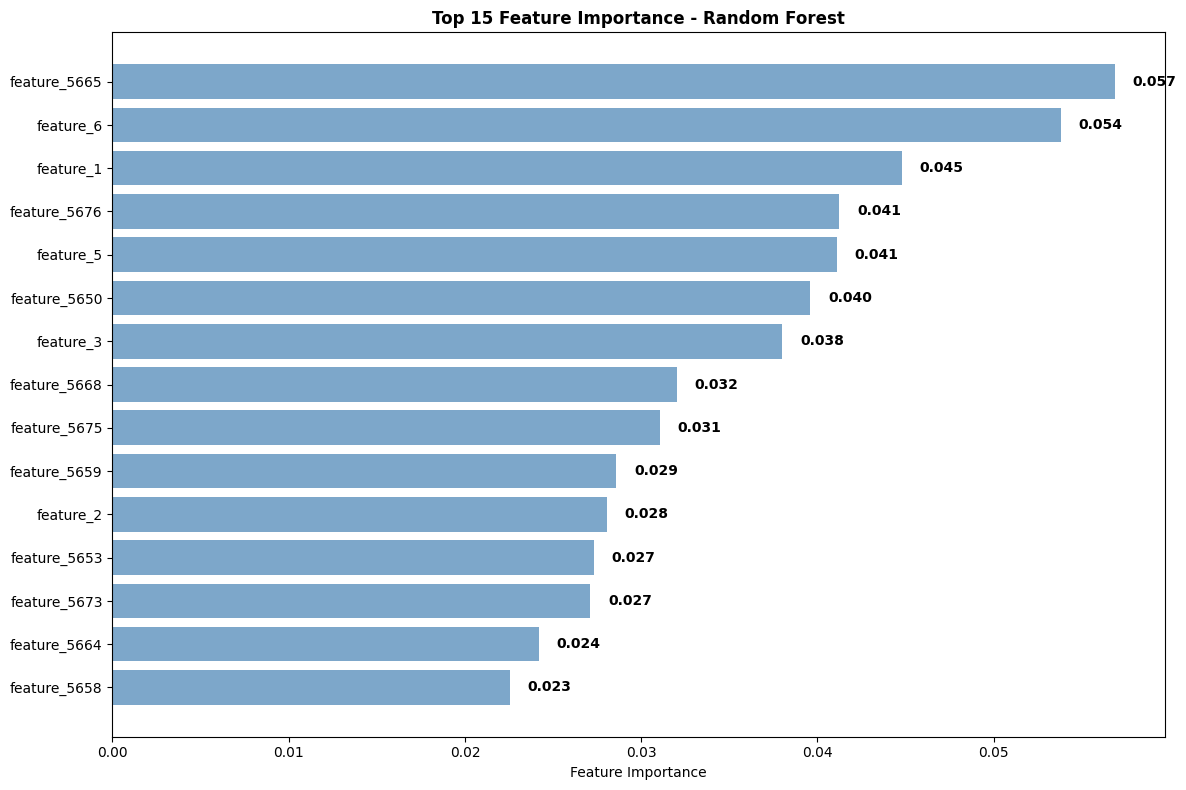


Top 10 Most Important Features:
           feature  importance
5665  feature_5665      0.0569
6        feature_6      0.0538
1        feature_1      0.0448
5676  feature_5676      0.0412
5        feature_5      0.0411
5650  feature_5650      0.0396
3        feature_3      0.0380
5668  feature_5668      0.0320
5675  feature_5675      0.0311
5659  feature_5659      0.0286


In [34]:
# Extract feature importance from the best F1 model
best_model = models[best_f1_model]
classifier = best_model.named_steps['classifier']

print(f"🔍 FEATURE IMPORTANCE ANALYSIS")
print(f"Best model: {best_f1_model}")
print("=" * 40)

try:
    if hasattr(classifier, 'feature_importances_'):
        importance_scores = classifier.feature_importances_
        
        # Create feature importance DataFrame using original feature names
        feature_names = X_train.columns.tolist()
        
        # Note: After preprocessing, we have more features due to one-hot encoding
        # For simplicity, we'll show the top important features with generic names
        if len(importance_scores) > len(feature_names):
            feature_names = [f'feature_{i}' for i in range(len(importance_scores))]
        
        importance_df = pd.DataFrame({
            'feature': feature_names[:len(importance_scores)],
            'importance': importance_scores
        }).sort_values('importance', ascending=False)
        
        # Plot top 15 features
        top_features = importance_df.head(15)
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(range(len(top_features)), top_features['importance'], 
                       color='steelblue', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Feature Importance - {best_f1_model}', fontweight='bold')
        plt.gca().invert_yaxis()
        
        # Add importance values on bars
        for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{importance:.3f}', ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        print(importance_df.head(10))
        
    else:
        print("Selected model does not have feature importance attribute")
        
except Exception as e:
    print(f"Feature importance extraction failed: {e}")
    print("Continuing without feature importance analysis...")

### 11. Save Models and Results

In [35]:
# Save all ensemble models
os.makedirs('artifacts/models', exist_ok=True)
os.makedirs('artifacts/reports', exist_ok=True)

# Update models dictionary with voting ensemble
models['Voting Ensemble'] = voting_ensemble

model_files = {
    'random_forest_optimized.pkl': rf_optimized,
    'xgboost_optimized.pkl': xgb_optimized,
    'catboost_optimized.pkl': catboost_optimized,
    'voting_ensemble.pkl': voting_ensemble
}

print("💾 SAVING MODEL ARTIFACTS")
print("=" * 30)

for filename, model in model_files.items():
    filepath = f'artifacts/models/{filename}'
    joblib.dump(model, filepath)
    print(f"✅ Saved {filename}")

# Save model comparison results
comparison_df.to_csv('artifacts/reports/ensemble_model_comparison.csv')
print(f"✅ Saved model comparison to: artifacts/reports/ensemble_model_comparison.csv")

# Save feature importance if available
if 'importance_df' in locals():
    importance_df.to_csv('artifacts/reports/feature_importance.csv', index=False)
    print(f"✅ Saved feature importance to: artifacts/reports/feature_importance.csv")

print("\n🎉 ENSEMBLE METHODS NOTEBOOK COMPLETED!")
print(f"⏰ Completion time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

💾 SAVING MODEL ARTIFACTS
✅ Saved random_forest_optimized.pkl
✅ Saved xgboost_optimized.pkl
✅ Saved catboost_optimized.pkl
✅ Saved voting_ensemble.pkl
✅ Saved model comparison to: artifacts/reports/ensemble_model_comparison.csv
✅ Saved feature importance to: artifacts/reports/feature_importance.csv

🎉 ENSEMBLE METHODS NOTEBOOK COMPLETED!
⏰ Completion time: 2025-08-23 17:18:53


### 12. Summary and Next Steps

In [36]:
# Final summary
print("📋 ENSEMBLE METHODS IMPLEMENTATION SUMMARY")
print("=" * 55)

print(f"\n🌳 RANDOM FOREST (Bagging):")
print(f"   • Method: Bootstrap Aggregating")
print(f"   • Test F1 Score: {model_results['Random Forest']['f1']:.4f}")
print(f"   • Test ROC-AUC: {model_results['Random Forest']['roc_auc']:.4f}")

print(f"\n🚀 XGBOOST (Gradient Boosting):")
print(f"   • Method: Extreme Gradient Boosting")
print(f"   • Test F1 Score: {model_results['XGBoost']['f1']:.4f}")
print(f"   • Test ROC-AUC: {model_results['XGBoost']['roc_auc']:.4f}")

print(f"\n🐱 CATBOOST (Advanced Boosting):")
print(f"   • Method: Categorical Boosting")
print(f"   • Test F1 Score: {model_results['CatBoost']['f1']:.4f}")
print(f"   • Test ROC-AUC: {model_results['CatBoost']['roc_auc']:.4f}")

print(f"\n🗳️  VOTING ENSEMBLE:")
print(f"   • Method: Soft Voting (Probability-based)")
print(f"   • Combines: Random Forest + XGBoost + CatBoost")
print(f"   • Test F1 Score: {model_results['Voting Ensemble']['f1']:.4f}")
print(f"   • Test ROC-AUC: {model_results['Voting Ensemble']['roc_auc']:.4f}")

print(f"\n🏆 BEST MODELS:")
print(f"   • Best F1 Score: {best_f1_model} ({model_results[best_f1_model]['f1']:.4f})")
print(f"   • Best ROC-AUC: {best_roc_model} ({model_results[best_roc_model]['roc_auc']:.4f})")

print(f"\n🎯 CLASS IMBALANCE HANDLING:")
print(f"   • SMOTE applied to all models")
print(f"   • Focused on F1 and ROC-AUC metrics")
print(f"   • Stratified sampling maintained")

print(f"\n🔄 NEXT STEPS:")
print(f"   1. Comprehensive model evaluation (notebook 5)")
print(f"   2. Business impact analysis (notebook 6)")
print(f"   3. Threshold optimization for business objectives")
print(f"   4. Cost-benefit analysis of predictions")

print(f"\n✅ All ensemble models saved to: artifacts/models/")
print(f"✅ Model comparison saved to: artifacts/reports/")
print(f"\n🎊 READY FOR MODEL EVALUATION PHASE!")

📋 ENSEMBLE METHODS IMPLEMENTATION SUMMARY

🌳 RANDOM FOREST (Bagging):
   • Method: Bootstrap Aggregating
   • Test F1 Score: 0.6195
   • Test ROC-AUC: 0.8364

🚀 XGBOOST (Gradient Boosting):
   • Method: Extreme Gradient Boosting
   • Test F1 Score: 0.5836
   • Test ROC-AUC: 0.8347

🐱 CATBOOST (Advanced Boosting):
   • Method: Categorical Boosting
   • Test F1 Score: 0.6000
   • Test ROC-AUC: 0.8426

🗳️  VOTING ENSEMBLE:
   • Method: Soft Voting (Probability-based)
   • Combines: Random Forest + XGBoost + CatBoost
   • Test F1 Score: 0.6018
   • Test ROC-AUC: 0.8446

🏆 BEST MODELS:
   • Best F1 Score: Random Forest (0.6195)
   • Best ROC-AUC: Voting Ensemble (0.8446)

🎯 CLASS IMBALANCE HANDLING:
   • SMOTE applied to all models
   • Focused on F1 and ROC-AUC metrics
   • Stratified sampling maintained

🔄 NEXT STEPS:
   1. Comprehensive model evaluation (notebook 5)
   2. Business impact analysis (notebook 6)
   3. Threshold optimization for business objectives
   4. Cost-benefit analysi